In [18]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
from tqdm import tqdm
import matplotlib.image as mpimg
from random import choice
from math import log
from skimage.filters import unsharp_mask
from skimage import io, morphology
from skimage import exposure
import cv2
from tqdm import tqdm
from math import sqrt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [19]:
def add_gaussian_noise(image, mean=0, sigma=25):
#Aggiunge rumore gaussiano all'immagine
    row, col= image.shape
    noise = np.random.normal(mean, sigma, (row, col))
    noisy_image = np.clip(image + noise, 0, 1)
    return noisy_image

def equalize_within_mask(image, mask, range_min=0, range_max=1):
    # Applica la maschera all'immagine
    masked_image = np.copy(image)
    masked_image[~mask] = 0

    # Calcola l'istogramma dell'immagine all'interno della maschera
    hist, bin_centers = exposure.histogram(masked_image)

    # Equalizza l'istogramma all'interno del range specificato
    equalized_image = exposure.rescale_intensity(masked_image, in_range='image', out_range = (range_min,range_max))

    image_to_add = np.copy(image)
    image_to_add[mask] = 0
    equalized_image = equalized_image + image_to_add

    return equalized_image

def low_pass(img,size):

    kernel = np.ones((size,size))
    kernel = kernel/(size**2)
    filtered_img = convolve2d(img, kernel, mode='same', boundary='symm')
    return filtered_img

def enchance_contrast(img,f):

    media = np.mean(img)
    diff = img - np.array(media)
    img_con = img + f*diff
    img_con[img_con < 0] = 0
    img_con[img_con > 1] = 1

    return img_con

def normalize_within_mask(img,mask):
    img_new = (img - np.min(img[mask])) / (np.max(img[mask]) - np.min(img[mask]))
    return img_new

def standardize_within_mask(img,mask):
    img_new = (img - np.mean(img[mask])) / np.std(img[mask])
    return img_new

def gaussian_kernel(size, sigma):
    """
    Crea un kernel gaussiano 2D.
    """
    kernel = np.fromfunction(
        lambda x, y: (1/(2*np.pi*sigma**2)) * np.exp(-((x - size//2)**2 + (y - size//2)**2)/(2*sigma**2)),
        (size, size)
    )
    return kernel / np.sum(kernel)

def create_elliptical_kernel(a, b):
    """
    Crea un kernel elittico di dimensioni 2a x 2b.

    Parametri:
    - a: lunghezza dell'asse x dell'ellisse.
    - b: lunghezza dell'asse y dell'ellisse.

    Ritorna:
    - Un kernel elittico normalizzato.
    """
    y, x = np.ogrid[-b:b, -a:a]
    mask = (x**2) / ((a-1)**2) + (y**2) / ((b-1)**2) <= 1
    kernel = np.zeros((2 * b, 2 * a), dtype=np.float32)
    kernel[mask] = 1.0
    return kernel / kernel.sum()

def apply_average_filter(image_array, a,b):
    kernel = create_elliptical_kernel(a,b)
    filtered_image = cv2.filter2D(image_array, -1, kernel)
    return filtered_image


def gaussian_blur(image, kernel_size, sigma):
    """
    Applica un filtro gaussiano all'immagine utilizzando il kernel definito.
    """
    # Crea il kernel gaussiano
    kernel = gaussian_kernel(kernel_size, sigma)

    # Applica la convoluzione tra l'immagine e il kernel gaussiano
    blurred_image = cv2.filter2D(image, -1, kernel)

    return blurred_image

def balance_luminosity_add(img,mask,kernel_size,difference):

    size = np.shape(img)[0]
    kernel = np.ones((kernel_size,kernel_size))

    media_im = np.mean(img[mask])

    binary_mask = np.zeros(np.shape(mask))
    binary_mask[mask] = 1

    trsh = (kernel_size**2)/2
    available_pos = []

    for i in range(0,size-kernel_size,int(kernel_size/2)):
        for j in range(0,size-kernel_size,int(kernel_size/2)):
            check_pos = np.sum(binary_mask[i:i+kernel_size,j:j+kernel_size] * kernel)
            if check_pos > trsh:
                available_pos.append((i,j))

    new_image = np.copy(img)

    for coords in available_pos:
        y = coords[0]
        x = coords[1]
        media_loc = np.mean(img[y:y+kernel_size,x:x+kernel_size])
        if abs(media_loc-media_im) >difference:
            correzione_l = (media_im - media_loc)/10
            patch = new_image[y:y+kernel_size,x:x+kernel_size] + correzione_l
            patch[patch < 0] = 0.
            patch[patch > 1] = 1.0
            new_image[y:y+kernel_size,x:x+kernel_size] = patch

    return new_image

def remove_stains(img,diameter,mask):
    radius = diameter//2
    a = int(radius * np.shape(img)[0]/2048)
    b = int(radius * np.shape(img)[1]/2048)
    img[mask] = np.mean(img[~mask])
    img_l = apply_average_filter(img,a,b)
    img_l[mask] = np.mean(img[~mask])
    img_diff = img - img_l
    img_diff_n = normalize_within_mask(img_diff,~mask)
    img_diff_n[mask] = np.mean(img_diff_n[~mask])
    return img_diff_n

import numpy as np


def pre_process(img):
  mask_cerchio = img < 6/255
  img_ar = normalize_within_mask(img,~mask_cerchio)
  h,w = np.shape(img_ar)
  f_norm = sqrt(h**2 + w**2)/2048
  img_ar[mask_cerchio] = np.mean(img_ar[~mask_cerchio])

  stain_dimensions =list(range(400,200,-50)) + list(range(200,49,-25))
  for dimension in stain_dimensions:
      img_diff = remove_stains(img_ar,dimension,mask_cerchio)
      img_ar = img_diff

  img_f = gaussian_blur(img_diff, kernel_size=int(12*f_norm), sigma=(5*f_norm))
  img_f[mask_cerchio] = np.mean(img_f[~mask_cerchio])

  img_gamma = img_f ** log(0.5,np.mean(img_f[~mask_cerchio]))
  img_gamma[mask_cerchio] = np.mean(img_gamma[~mask_cerchio])

  img_cor = 1 - img_gamma

  img_sh =  unsharp_mask(img_cor, radius=int(2048*f_norm/20), amount=5)

  img_e = exposure.equalize_adapthist(img_sh,int(64*f_norm))
  img_std = standardize_within_mask(img_e,~mask_cerchio)
  img_std = normalize_within_mask(img_std,~mask_cerchio)
  img_std[mask_cerchio] = 1.0
  return img_std

PREPROCESS

In [20]:
#ESEGUI QUESTA CELLA CON ESTREMA CAUTELA, SVUOTA LE CARTELLE
# IN DETTAGLI SVUOTA : Preprocess, Construction_set, Test_set, Ground_resized, Ground_construction_set, Ground_test_set

path_preprocess = '/content/drive/MyDrive/EIMproject/RETINA/Preprocess'
path_construction = '/content/drive/MyDrive/EIMproject/RETINA/Construction_set'
path_test = '/content/drive/MyDrive/EIMproject/RETINA/Test_set'
path_ground_resized = '/content/drive/MyDrive/EIMproject/RETINA/Ground_resized'
path_ground_construction = '/content/drive/MyDrive/EIMproject/RETINA/Ground_construction_set'
path_test_construction = '/content/drive/MyDrive/EIMproject/RETINA/Ground_test_set'

lista_p = [path_preprocess,path_construction, path_test, path_ground_resized, path_ground_construction, path_test_construction]
for p in lista_p:
    if not os.path.exists(p):
        os.makedirs(p)

    # Scorri tutti i file nella cartella e elimina ciascun file
#for nome_file in os.listdir(p):
#    percorso_file = os.path.join(p, nome_file)
#    if os.path.isfile(percorso_file):
#          os.remove(percorso_file)

In [21]:
path_input = '/content/drive/MyDrive/EIMproject/RETINA/Original'
path_output = '/content/drive/MyDrive/EIMproject/RETINA/Preprocess'
path_manual = '/content/drive/MyDrive/EIMproject/RETINA/Ground truth'
path_ground_resized = '/content/drive/MyDrive/EIMproject/RETINA/Ground_resized'

In [22]:
lista_im = os.listdir(path_input)
medie_rumore = [-0.05,0,0,0, 0.05]                       #Valori che influenzano come saranno le nostre immaigni
sigme_rumore = [0.007,0.01, 0.02]                           # i valori ripetuti servono a rendere disomogenea la distribuzione
aspect_ratio = [1,1,3/4,9/16, 2/3]
sizes = [3500, 2048, 1024,512]


for im in tqdm(lista_im):
    image_path = os.path.join(path_input, im)
    img_o = Image.open(image_path)
    img_m = Image.open(os.path.join(path_manual,im))
    dim = choice(sizes)
    ar = choice(aspect_ratio)                                   #prendiamo una dimensione a caso
    img_rsz = img_o.resize((dim, int(dim * ar)))
    img_m_rsz = img_m.resize((dim, int(dim * ar)))           #riscaliamo
    img_g = np.array(img_rsz)[:,:,1]/255
    img_no = add_gaussian_noise(img_g,choice(medie_rumore), choice(sigme_rumore))  #CAMBIARE img_g con img_p se preprocess
    img_p= pre_process(img_no)           # Penso che il preprocess vada fatto a questo punto
    img_8 = (img_p*255).astype(np.uint8)                        #immagine a 8 bit
    img_to_save = Image.fromarray(img_8)
    img_to_save.save(os.path.join(path_output,im))
    img_m_rsz.save(os.path.join(path_ground_resized,im))


100%|██████████| 600/600 [2:34:29<00:00, 15.45s/it]


In [23]:
I=Image.open("/content/drive/MyDrive/EIMproject/RETINA/Preprocess/101_A.png")
O=Image.open("/content/drive/MyDrive/EIMproject/RETINA/Ground_resized/101_A.png")
I=np.array(I)
O=np.array(O)

CLUSTERING

In [24]:
!pip install skan
from skimage.morphology import skeletonize
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from skimage import img_as_ubyte, measure, morphology, feature, color
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from skan import Skeleton, summarize
from sklearn.model_selection import train_test_split
import shutil

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 31.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 346.6/346.6 kB 28.7 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
bigframes 0.17.0 requires pandas<2.1.4,>=1.5.0, but you have pandas 2.1.4 which is incompatible.
google-colab 1.0.0 requires pandas==1.5.3, but you have pandas 2.1.4 which is incompatible.


In [25]:
def calcola_vasi_per_tipo(img):

  if np.max(img) == 0:
    print('immagine vuota')
    return 0, 0
  skt = skeletonize(img)

  skeleton_data = Skeleton(skt)
  skel_summary = summarize(skeleton_data)

  # count how many branches have branch-type = 1 and 2
  N_J2E = len(skel_summary[skel_summary['branch-type'] == 1])
  N_J2J = len(skel_summary[skel_summary['branch-type'] == 2])

  return N_J2E, N_J2J

def calculate_glcm_features(gray_image):
    # Specify the distances and angles for GLCM
    distances = [3, 7, 11]
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]

    # Calculate GLCM
    glcm = greycomatrix(gray_image, distances=distances, angles=angles, symmetric=True, normed=True)

    # Calculate GLCM features
    contrast = np.mean(greycoprops(glcm, 'contrast'))
    dissimilarity = np.mean(greycoprops(glcm, 'dissimilarity'))
    homogeneity = np.mean(greycoprops(glcm, 'homogeneity'))
    energy = np.mean(greycoprops(glcm, 'energy'))
    correlation = np.mean(greycoprops(glcm, 'correlation'))

    return contrast, dissimilarity, homogeneity, energy, correlation

In [26]:
path_im = path_output
path_man = '/content/drive/MyDrive/EIMproject/RETINA/Ground truth'
path_man_resized = '/content/drive/MyDrive/EIMproject/RETINA/Ground_resized'
path_constr = '/content/drive/MyDrive/EIMproject/RETINA/Construction_set'
path_test = '/content/drive/MyDrive/EIMproject/RETINA/Test_set'
path_constr_man = '/content/drive/MyDrive/EIMproject/RETINA/Ground_construction_set'
path_test_man = '/content/drive/MyDrive/EIMproject/RETINA/Ground_test_set'

In [27]:
list_im = os.listdir(path_im)
list_man = os.listdir(path_man)

n_e_list = []
n_j_list = []
max_size = []
asp_ratio = []

for file_im in tqdm(list_man):
  image_path_m = os.path.join(path_man,file_im)
  image_path = os.path.join(path_im,file_im)
  img = Image.open(image_path)
  img_m = Image.open(image_path_m)
  max_size.append(max(img.size[0], img.size[1]))
  asp_ratio.append(img.size[0]/img.size[1])
  pic = np.array(img_m)
  n_e, n_j = calcola_vasi_per_tipo(pic)
  n_e_list.append(n_e)
  n_j_list.append(n_j)


asp_ratio = asp_ratio -np.min(asp_ratio)/(np.max(asp_ratio)-np.min(asp_ratio))
max_size = max_size -np.min(max_size)/(np.max(max_size)-np.min(max_size))
n_e_list = n_e_list -np.min(n_e_list)/(np.max(n_e_list)-np.min(n_e_list))
n_j_list = n_j_list -np.min(n_j_list)/(np.max(n_j_list)-np.min(n_j_list))

asp_ratio = (asp_ratio - np.mean(asp_ratio))/np.std(asp_ratio)
max_size = (max_size - np.mean(max_size))/np.std(max_size)
n_e_list = (n_e_list - np.mean(n_e_list))/np.std(n_e_list)
n_j_list = (n_j_list - np.mean(n_j_list))/np.std(n_j_list)


 72%|███████▏  | 432/600 [17:31<06:52,  2.45s/it]

immagine vuota


 72%|███████▏  | 434/600 [17:33<05:02,  1.82s/it]

immagine vuota


100%|██████████| 600/600 [38:57<00:00,  3.90s/it]


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-28-d509c089c90b>:16: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[:, 0], X[:, 1], cmap='viridis', edgecolor='k', s=50)


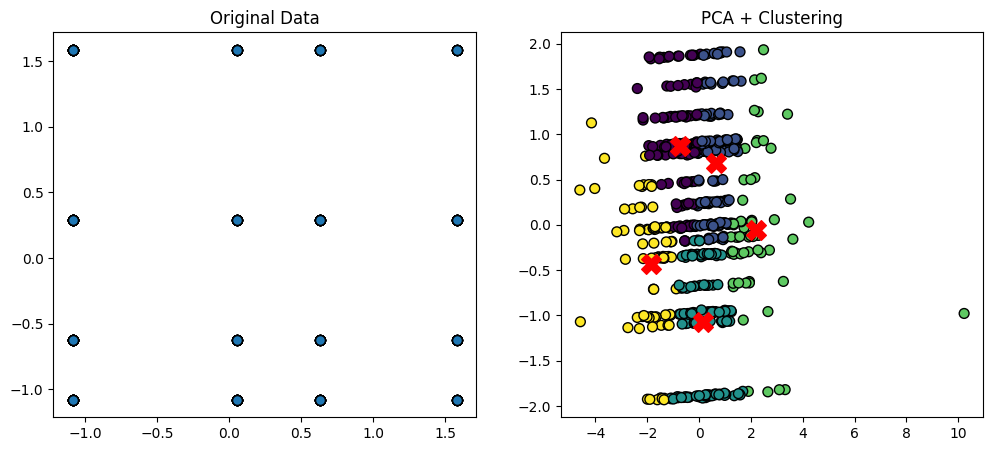

In [28]:
pca = PCA(n_components=2)

# Convert lists to NumPy arrays and stack them vertically
X = np.vstack((asp_ratio,max_size, n_e_list, n_j_list)).T  # Transpose to make it a 2D array

X_pca = pca.fit_transform(X)

kmeans = KMeans(n_clusters=5, random_state=42)
y_kmeans = kmeans.fit_predict(X_pca)

# Visualize the original data and the obtained clusters
plt.figure(figsize=(12, 5))

# Plot original data
plt.subplot(1, 2, 1)
plt.scatter(X[:, 0], X[:, 1], cmap='viridis', edgecolor='k', s=50)
plt.title('Original Data')

# Plot data transformed with PCA
plt.subplot(1, 2, 2)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_kmeans, cmap='viridis', edgecolor='k', s=50)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='X', s=200, label='Centroids')
plt.title('PCA + Clustering')

plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

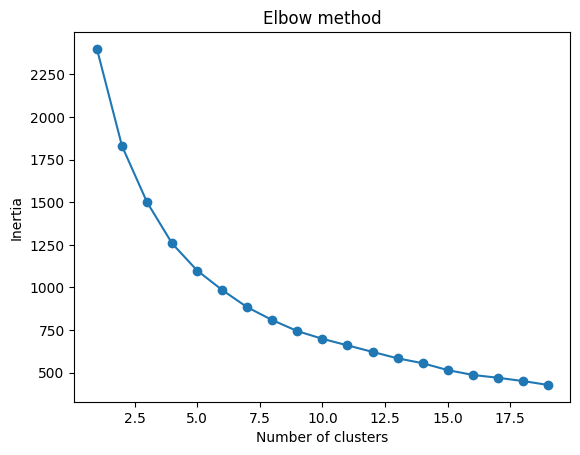

In [29]:
inertias = []

for i in range(1,20):
    kmeans = KMeans(n_clusters=i, random_state = 0 )
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,20), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-30-89f2c73b55be>:16: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[:,0], X[:,1], cmap='viridis', edgecolor='k', s=50)


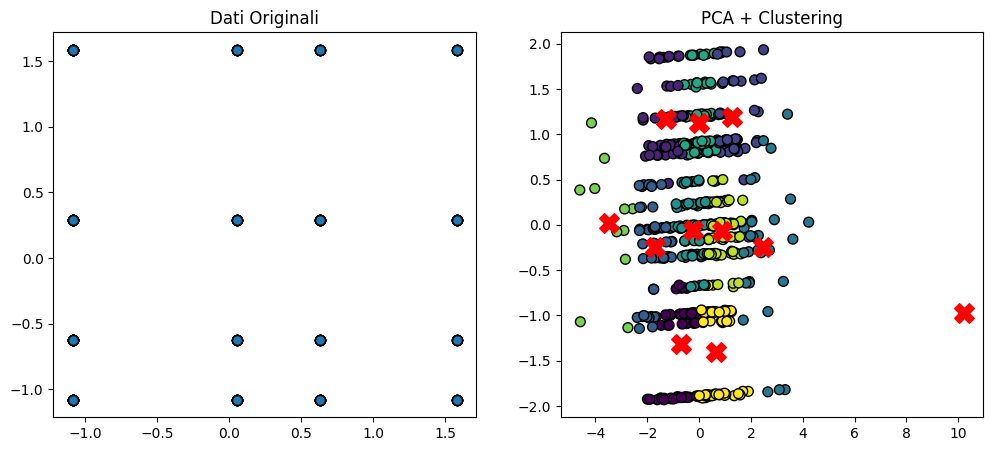

In [30]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

#!!!!!!!!!!!!!!!
#MODIFICA QUA IL NUMERO DI CLUSTER
n_clusters = 11                          #<- <- <- <-

kmeans = KMeans(n_clusters, random_state=42)
y_kmeans = kmeans.fit_predict(X_pca)

# Visualizza i dati originali e i cluster ottenuti
plt.figure(figsize=(12, 5))

# Plot dati originali
plt.subplot(1, 2, 1)
plt.scatter(X[:,0], X[:,1], cmap='viridis', edgecolor='k', s=50)
plt.title('Dati Originali')

# Plot dati trasformati con PCA
plt.subplot(1, 2, 2)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_kmeans, cmap='viridis', edgecolor='k', s=50)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='X', s=200, label='Centroidi')
plt.title('PCA + Clustering')
plt.legend

plt.show()

In [31]:
from collections import Counter
conteggio = Counter(y_kmeans)

# Trova gli elementi che appaiono solo una volta
elementi_unici = [elemento for elemento, occorrenza in conteggio.items() if occorrenza == 1]

elementi_non_unici = [elemento for elemento, occorrenza in conteggio.items() if occorrenza > 1]
for element in elementi_unici:
  y_kmeans[y_kmeans == element] = choice(elementi_non_unici)
'''
pazconcluster = []
for i in range(len(y_kmeans)):
    diz = {}
    diz['pz'] = lista_im[i]
    diz['cluster'] = y_kmeans[i]
    pazconcluster.append(diz)

df_paz = pd.DataFrame(pazconcluster)
'''
lista_constr = []
lista_test = []
#for i in range(n_clusters-1):
    #df_cluster = df_paz[df_paz['cluster'] == i]
constr, test = train_test_split(lista_im, train_size=0.8,test_size = 0.2, stratify = y_kmeans,random_state=42)
    #constr_temp = list(constr['pz'])
    #test_temp = list(test['pz'])
    #lista_constr = lista_constr + constr_temp
    #lista_test = lista_test + test_temp

In [32]:
for pz in tqdm(constr):
    percorso_file_originale = os.path.join(path_im, pz)
    percorso_destinazione = os.path.join(path_constr,pz)
    percorso_file_originale_m = os.path.join(path_ground_resized, pz)
    percorso_destinazione_m = os.path.join(path_constr_man,pz)
    shutil.move(percorso_file_originale, percorso_destinazione)
    shutil.move(percorso_file_originale_m, percorso_destinazione_m)

for pz in tqdm(test):
    percorso_file_originale = os.path.join(path_im, pz)
    percorso_destinazione = os.path.join(path_test,pz)
    shutil.move(percorso_file_originale, percorso_destinazione)
    percorso_file_originale_m = os.path.join(path_ground_resized, pz)
    percorso_destinazione_m = os.path.join(path_test_man,pz)
    shutil.move(percorso_file_originale_m, percorso_destinazione_m)

100%|██████████| 120/120 [00:05<00:00, 23.13it/s]
